# Sequence Prediction with Simple RNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


## Synthetic Data Set Generation

In [2]:
# helper functions for data gneration and plotting

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
# create and split data set

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
# slice dataset into sequence windows

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Train the RNN for Learning Rate optimization
Note that the RNN layer needs a higher dimenison. This can be achieved with Lambda layer and does not need modification of the input data.

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0) # scale up output for better tanh activation response
  ])

# lr scheduler that slowly decreases lr
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# start training, implement lr schedulercallback
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 272ms/step - loss: 195.6164 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 38ms/step - loss: 194.5325 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 192.9727 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 192.1908 - mae: 192.4087
Epoch 5/100
8/8 [==============================] - 0s 36ms/step - loss: 190.2552 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 38ms/step - loss: 187.3451 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 38ms/step - loss: 185.5730 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 40ms/step - loss: 182.9678 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 179.8839 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 0s 38ms/step - loss: 175.3425 - mae: 176.0968
Epoch 11/100
8/8 [==========

[1e-08, 0.0001, 0, 30]

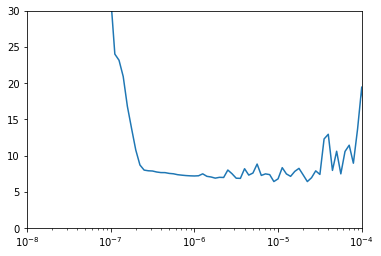

In [6]:
# Choose the highest learning rate with lowest los. In  this case ca. lr = 10-5.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## Train the RNN with optimized lr

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
  ])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9) # here goes the optimized lr

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 170ms/step - loss: 80.8704 - mae: 83.5782
Epoch 2/400
8/8 [==============================] - 0s 38ms/step - loss: 24.4966 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 0s 40ms/step - loss: 18.2014 - mae: 18.7075
Epoch 4/400
8/8 [==============================] - 0s 36ms/step - loss: 14.2669 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 0s 35ms/step - loss: 10.8970 - mae: 11.2668
Epoch 6/400
8/8 [==============================] - 0s 38ms/step - loss: 11.3464 - mae: 12.5379
Epoch 7/400
8/8 [==============================] - 0s 40ms/step - loss: 12.7849 - mae: 13.1566
Epoch 8/400
8/8 [==============================] - 0s 37ms/step - loss: 12.3041 - mae: 12.5536
Epoch 9/400
8/8 [==============================] - 0s 36ms/step - loss: 13.6219 - mae: 13.5991
Epoch 10/400
8/8 [==============================] - 0s 36ms/step - loss: 14.9535 - mae: 14.9965
Epoch 11/400
8/8 [==============================

## Make Predictions

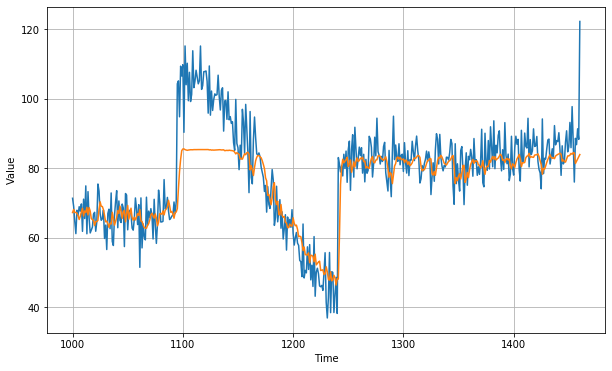

In [8]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.153807

<Figure size 432x288 with 0 Axes>

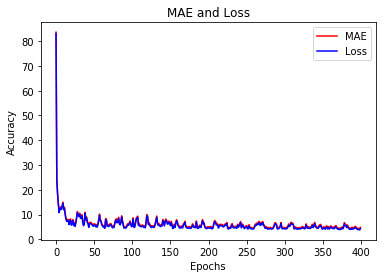

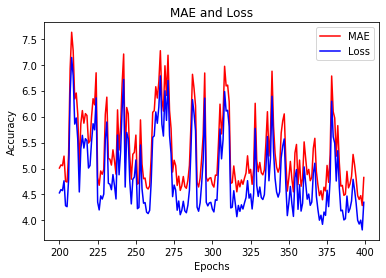

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()